In [1]:
import pandas as pd
import glob
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import gradio as gr
import pickle

In [2]:
#Using the glob package to read all files with datatype csv contained in the folder
files = glob.glob("C:/Users/uchei/OneDrive/Desktop/csvs_per_year/csvs_per_year**/*.csv")

df = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    df = df.append(csv)

In [3]:
df.head()

,date,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
0,2001-08-01 01:00:00,NaN,0.37,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,6.34,NaN,NaN,28079001,NaN,NaN,NaN
1,2001-08-01 01:00:00,1.5,0.34,1.49,4.1,0.07,56.250000,75.169998,2.11,42.160000,100.599998,1.73,8.11,1.24,10.82,28079035,NaN,NaN,NaN
2,2001-08-01 01:00:00,NaN,0.28,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,7.85,NaN,NaN,28079003,NaN,NaN,NaN
3,2001-08-01 01:00:00,NaN,0.47,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
4,2001-08-01 01:00:00,NaN,0.39,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,8.80,NaN,NaN,28079039,NaN,NaN,NaN


# Data Preprocessing

In [4]:
df.dtypes

date        object
BEN        float64
CO         float64
EBE        float64
MXY        float64
NMHC       float64
NO_2       float64
NOx        float64
OXY        float64
O_3        float64
PM10       float64
PXY        float64
SO_2       float64
TCH        float64
TOL        float64
station      int64
PM25       float64
NO         float64
CH4        float64
dtype: object

In [5]:
#date shouldn't be an onject dtype, change to datetime
df['date'] = pd.to_datetime(df.date, infer_datetime_format = True)

CO, TCH and CH4 are measured in mgm-3. We need to convert this to μgm-3.

In [6]:
#Divide columns by 1000 to get desired unit
df['CO'] = df['CO']/1000
df['TCH'] = df['TCH']/1000
df['CH4'] = df['CH4']/1000

## Null Value Treatment

In [7]:
df.isnull().sum()

date             0
BEN        2766540
CO         1157212
EBE        2806500
MXY        3492809
NMHC       2722912
NO_2         21174
NOx        1431949
OXY        3492529
O_3         816492
PM10        946969
PXY        3492640
SO_2       1032264
TCH        2721783
TOL        2769295
station          0
PM25       2991800
NO         2275827
CH4        3793374
dtype: int64

Because there are different stations contained in this dataset, treating null values on the main dataset could lead to wrong interpretation of data. Let's break the data down into groups by using their station codes.

In [8]:
df_stations = df.groupby('station')
casa_de_campo = df_stations.get_group(28079024)
casa_de_campo.index = casa_de_campo.date
casa_de_campo = casa_de_campo.drop(['date'], axis = 1)
casa_de_campo.head()

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2001-08-01 01:00:00,0.80,0.00043,0.71,1.20,0.10,27.190001,29.700001,0.76,56.990002,114.300003,0.49,10.84,0.00142,3.43,28079024,NaN,NaN,NaN
2001-08-01 02:00:00,0.74,0.00051,0.78,1.23,0.12,36.980000,38.310001,0.78,46.939999,78.949997,0.51,11.01,0.00138,3.72,28079024,NaN,NaN,NaN
2001-08-01 03:00:00,1.07,0.00043,1.09,2.04,0.11,32.250000,33.310001,1.14,52.419998,61.790001,0.81,10.76,0.00137,6.39,28079024,NaN,NaN,NaN
2001-08-01 04:00:00,0.81,0.00042,0.92,1.65,0.11,28.740000,29.820000,0.91,55.980000,58.320000,0.67,10.49,0.00137,5.14,28079024,NaN,NaN,NaN
2001-08-01 05:00:00,0.72,0.00042,0.94,1.67,0.09,26.270000,28.290001,0.91,61.160000,51.660000,0.67,10.29,0.00145,5.88,28079024,NaN,NaN,NaN


In [9]:
casa_de_campo.shape

(151416, 18)

# Missing Value Treatment

In [10]:
casa_de_campo.isnull().sum()/151416 * 100

BEN         8.919797
CO          1.081127
EBE        11.659270
MXY        52.230279
NMHC        1.944312
NO_2        1.079146
NOx        39.737544
OXY        52.230279
O_3         1.506446
PM10        1.557299
PXY        52.229619
SO_2        1.045464
TCH         1.911291
TOL         8.927722
station     0.000000
PM25       19.554737
NO         58.006419
CH4        96.756618
dtype: float64

Here, we can see so many columns that have way more values as null than those that actually have recorded values. Let's drop them to avoid bias when treating null values.

In [11]:
casa_de_campo = casa_de_campo.drop(['MXY', 'OXY', 'PXY', 'NO', 'CH4', 'station'], axis = 1)

In [12]:
casa_de_campo.skew()

BEN      8.850090
CO       2.098004
EBE     11.806298
NMHC     1.627515
NO_2     1.400706
NOx      2.535055
O_3      0.410557
PM10     2.645797
SO_2     2.178624
TCH      3.163313
TOL      4.787562
PM25     2.017436
dtype: float64

With skewness, any column with a value less than or equal to 0.5 can have its null values imputed with the mean of the column. All others can be median.

In [13]:
casa_de_campo['O_3'].fillna(casa_de_campo['O_3'].mean(), inplace = True)
casa_de_campo['CO'].fillna(casa_de_campo['CO'].median(), inplace = True)
casa_de_campo['NMHC'].fillna(casa_de_campo['NMHC'].median(), inplace = True)
casa_de_campo['NO_2'].fillna(casa_de_campo['NO_2'].median(), inplace = True)
casa_de_campo['PM10'].fillna(casa_de_campo['PM10'].median(), inplace = True)
casa_de_campo['SO_2'].fillna(casa_de_campo['SO_2'].median(), inplace = True)
casa_de_campo['TCH'].fillna(casa_de_campo['TCH'].median(), inplace = True)

In [14]:
# Define MICE Imputer and fill missing values for all other columns
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

campo_imputed = pd.DataFrame(mice_imputer.fit_transform(casa_de_campo), columns=casa_de_campo.columns, index = casa_de_campo.index)

C:\Users\uchei\anaconda3\anaconda3.8\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [15]:
campo_imputed

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,SO_2,TCH,TOL,PM25
date,,,,,,,,,,,,
2001-08-01 01:00:00,0.80,0.00043,0.71,0.10,27.190001,29.700001,56.990002,114.300003,10.84,0.00142,3.43,36.665374
2001-08-01 02:00:00,0.74,0.00051,0.78,0.12,36.980000,38.310001,46.939999,78.949997,11.01,0.00138,3.72,26.422098
2001-08-01 03:00:00,1.07,0.00043,1.09,0.11,32.250000,33.310001,52.419998,61.790001,10.76,0.00137,6.39,21.317997
2001-08-01 04:00:00,0.81,0.00042,0.92,0.11,28.740000,29.820000,55.980000,58.320000,10.49,0.00137,5.14,20.194374
2001-08-01 05:00:00,0.72,0.00042,0.94,0.09,26.270000,28.290001,61.160000,51.660000,10.29,0.00145,5.88,18.195505
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-31 20:00:00,0.60,0.00040,0.40,0.10,92.000000,134.000000,1.000000,20.000000,6.00,0.00121,3.40,11.000000
2018-01-31 21:00:00,1.40,0.00070,1.10,0.19,130.000000,354.000000,1.000000,34.000000,12.00,0.00138,8.70,19.000000
2018-01-31 22:00:00,1.80,0.00070,1.70,0.19,129.000000,361.000000,1.000000,45.000000,11.00,0.00140,11.90,26.000000


In [16]:
#Checking stationarity of data
result = adfuller(campo_imputed['CO'].values)
print('p-value: %f' % result[1])

p-value: 0.000000


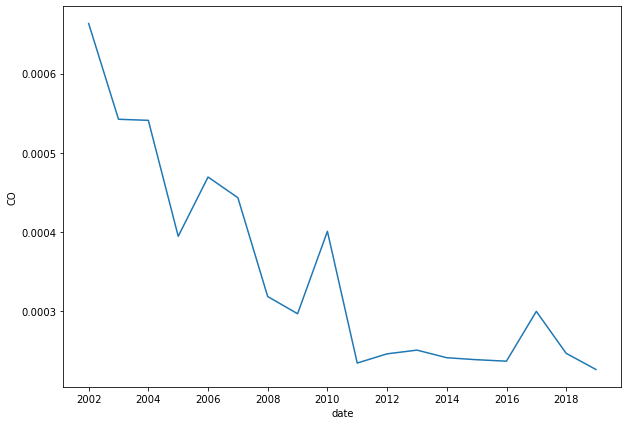

In [17]:
#Resample by year to get a yearly trend of Carbon Monoxide levels
yearly_campo = campo_imputed.resample("Y").mean()
plt.figure(figsize = (10, 7))
sns.lineplot(data = yearly_campo, x = yearly_campo.index, y = "CO")
plt.show()

# Resampling, Visualization and Modeling

To get a more detailed sense of the data, I will be resampling the data into different categories.

In [18]:
#Get the mean of values in the dataset on a weekly basis
weekly_campo = campo_imputed.resample("W").mean()
weekly_campo.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,SO_2,TCH,TOL,PM25
date,,,,,,,,,,,,
2001-01-07,0.300778,0.000609,0.634709,0.101257,22.724072,29.141138,32.513593,11.161497,8.999102,0.001360,2.664012,7.111696
2001-01-14,0.723155,0.000895,1.505188,0.190833,50.246667,96.241250,13.021190,24.191012,15.050119,0.001530,9.041607,13.771030
2001-01-21,0.359709,0.000765,0.809573,0.144464,31.454524,59.776762,22.960567,18.602143,11.679345,0.001447,4.085045,10.989644
2001-01-28,0.245893,0.000602,0.520044,0.104405,19.118274,32.080833,34.955595,11.409762,9.036905,0.001362,1.797560,7.793673
2001-02-04,0.527911,0.000896,1.107875,0.199107,46.180714,100.565164,18.813333,27.269583,16.739048,0.001536,5.555465,15.449894


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='Levls of Carbon Monoxide (μgm-3) '>)

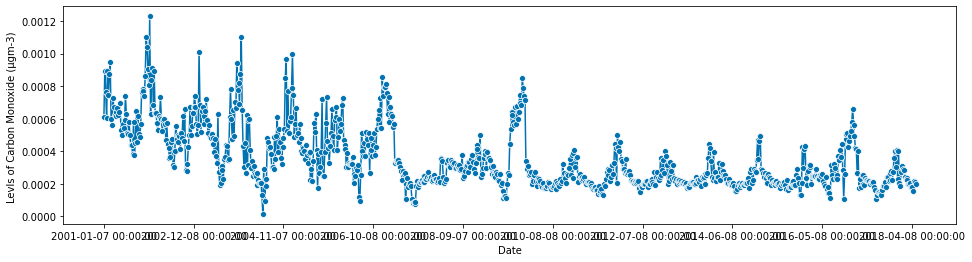

In [19]:
plot_series(weekly_campo['CO'], x_label = 'Date', y_label = 'Levls of Carbon Monoxide (μgm-3) ')

We can see that Carbon Monoxide levels were consistently high before 2007, before largely maintaining values below 0.004.

In [20]:
weekly_campo['CO'].idxmax()

Timestamp('2001-12-30 00:00:00', freq='W-SUN')

In [21]:
weekly_campo['CO'].max()

0.001228988092747472

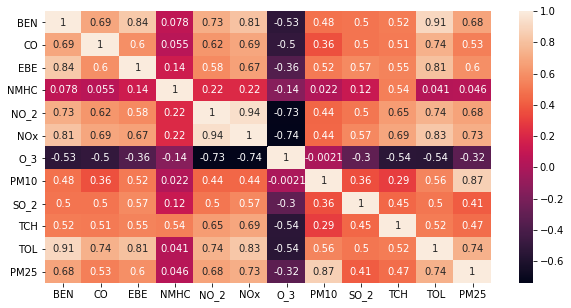

In [22]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(weekly_campo.corr(), annot = True, ax = ax)
plt.show()

NMHC and PM10 don't have a large effect on the value of Carbon Monoxide, as their correlation is low. Let's drop these and go with the other gases.

In [23]:
corr_weekly = weekly_campo.drop(['NMHC', 'PM10'], axis = 1)
corr_weekly.head()

,BEN,CO,EBE,NO_2,NOx,O_3,SO_2,TCH,TOL,PM25
2001-01-07,0.300778,0.000609,0.634709,22.724072,29.141138,32.513593,8.999102,0.001360,2.664012,7.111696
2001-01-14,0.723155,0.000895,1.505188,50.246667,96.241250,13.021190,15.050119,0.001530,9.041607,13.771030
2001-01-21,0.359709,0.000765,0.809573,31.454524,59.776762,22.960567,11.679345,0.001447,4.085045,10.989644
2001-01-28,0.245893,0.000602,0.520044,19.118274,32.080833,34.955595,9.036905,0.001362,1.797560,7.793673
2001-02-04,0.527911,0.000896,1.107875,46.180714,100.565164,18.813333,16.739048,0.001536,5.555465,15.449894


In [24]:
#Creating lag variables
dataframe = pd.DataFrame()
#On a weekly basis, the ideal number of lags should be 54.
for i in range(54, 0, -1):
    dataframe['t-' + str(i)] = corr_weekly.CO.shift(i)
#Combine the lagged dataframe with the original
lagged_data = pd.concat([corr_weekly, dataframe], axis = 1)
lagged_data.dropna(inplace = True)

In [25]:
#Slice the data into train and test
#The testing slice is for the final 26 weeks of the dataset
train = lagged_data.loc['2002-01-20' : '2017-11-05']
test = lagged_data.loc['2017-11-12' : '2018-05-06']
x_test = test.loc[:, test.columns != 'CO']
y_test = test['CO']
x_train = train.loc[:, train.columns != 'CO']
y_train = train['CO']

In [26]:
print("Training model...")
reg_forest = RandomForestRegressor(n_estimators = 100, random_state = 42)
rfe_weekly = RFE(estimator = reg_forest, n_features_to_select = 13)
fit_weekly = rfe_weekly.fit(x_train, y_train)

Training model...


In [27]:
col = RFE.get_support(fit_weekly).astype(int)
column_num = []
col = list(col)
col = [int(i) for i in col]
for index, col in enumerate(col):
    if col == 1:
        column_num.append(index)

In [28]:
important_x_train = x_train.iloc[:, column_num]
important_x_test = x_test.iloc[:, column_num]

In [29]:
important_x_train

,BEN,NO_2,NOx,O_3,TCH,TOL,PM25,t-41,t-40,t-5,t-4,t-2,t-1
2002-01-20,2.944489,70.213333,129.188809,11.912440,0.001434,13.312385,19.997153,0.000620,0.000640,0.000905,0.000804,0.000629,0.000837
2002-01-27,1.974905,48.908036,86.032951,18.923988,0.001382,9.440284,16.211731,0.000640,0.000668,0.000804,0.001229,0.000837,0.000912
2002-02-03,2.176837,66.617559,138.590833,11.280952,0.001399,10.015852,21.587195,0.000668,0.000622,0.001229,0.000629,0.000912,0.000685
2002-02-10,1.819524,37.090595,73.203274,23.403690,0.001325,7.442798,14.343423,0.000622,0.000642,0.000629,0.000837,0.000685,0.000894
2002-02-17,1.773452,44.074583,74.879842,23.569226,0.001389,6.771667,15.165010,0.000642,0.000696,0.000837,0.000912,0.000894,0.000634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-08,0.252763,30.495179,40.718781,41.016642,0.001296,1.725296,7.041773,0.000583,0.000662,0.000189,0.000212,0.000241,0.000242
2017-10-15,0.247024,49.401548,62.165385,44.643647,0.001338,1.449734,13.824825,0.000662,0.000562,0.000212,0.000179,0.000242,0.000216
2017-10-22,0.175378,28.428571,38.267857,41.767857,0.001319,0.699159,9.000000,0.000562,0.000495,0.000179,0.000241,0.000216,0.000265
2017-10-29,0.614308,46.809524,77.458333,29.764274,0.001325,4.376064,9.648810,0.000495,0.000422,0.000241,0.000242,0.000265,0.000223


In [30]:
new_weekly = reg_forest.fit(important_x_train, y_train)
predictions1 = new_weekly.predict(important_x_test)

In [31]:
correct = np.array(y_test)
sumvalue = np.sum(correct)
mape = np.sum(np.abs((correct - predictions1))) / sumvalue * 100
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.26 %.


In [32]:
weeklymodel = 'best_model3.sav'
pickle.dump(new_weekly, open(weeklymodel, 'wb'))

In [33]:
description = "Input levels of Pollutant Gases"
loaded_model = pickle.load(open(weeklymodel, 'rb'))
def grad(val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13):
    values = [[val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12, val13]]
    predictions = loaded_model.predict(values)
    output = list(predictions)
    output = [str(i) for i in output]
    output = "\n".join(output)
    return output

gr.Interface(grad, inputs = [gr.Number(label = "BEN"), gr.Number(label = "NO_2"), gr.Number(label = "NOx"), gr.Number(label = "O_3"),
                           gr.Number(label = "TCH"), gr.Number(label = "TOL"), gr.Number(label = "PM25"), gr.Number(label = "CO lagged by 41"),
                           gr.Number(label = "CO lagged by 40"), gr.Number(label = "CO lagged by 5"), gr.Number(label = "CO lagged by 4"),
                           gr.Number(label = "CO lagged by 2"), gr.Number(label = "CO lagged by 1")], outputs = gr.Textbox(label = "Levels of Carbon Monoxide")).launch()

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x20c80583760>, 'http://127.0.0.1:7860/', None)

In [34]:
#calculating bias
errors = [correct[i] - predictions1[i] for i in range(len(correct))]
bias = sum(errors) * 1.0/len(correct)
print('Bias: %f' % bias)

Bias: -0.000008


Our bias is very close to 0, however from the negative sign, we have slightly over forecast.

In [35]:
mae = mean_absolute_error(errors, predictions1)
print('MAE: %f' %mae)

MAE: 0.000271


In [36]:
mse = mean_squared_error(errors, predictions1)
print('MSE: %f' % mse)

MSE: 0.000000


In [37]:
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.000280


In [38]:
print(r2_score(y_test, predictions1))

0.8113461308214049


In [39]:
#As the predictions are in array,  we need to convert them to a DataFrame in order for the plot_series function to read it
predicted_df = pd.DataFrame(predictions1)
predicted_df['date'] = y_test.index
predicted_df['date'] = pd.to_datetime(predicted_df.date, infer_datetime_format = True)
predicted_df.index = predicted_df['date']
predicted_df = predicted_df.drop(['date'], axis = 1)
predicted_df.index = pd.to_datetime(predicted_df.index)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='CO Levels (μgm-3)'>)

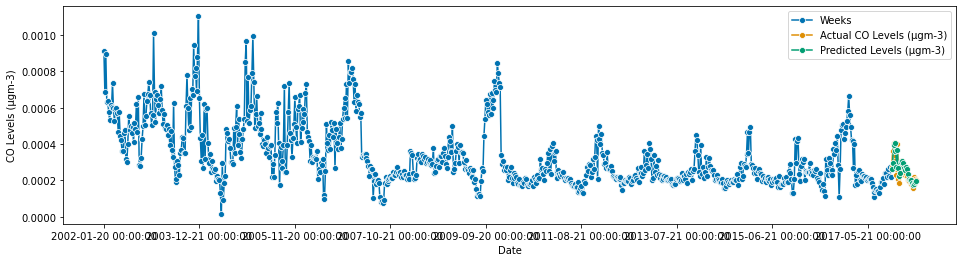

In [40]:
plot_series(y_train, y_test, predicted_df, x_label = 'Date', y_label = 'CO Levels (μgm-3)', labels = ['Weeks', 'Actual CO Levels (μgm-3)', 'Predicted Levels (μgm-3)'])

# Monthly Resampling

In [41]:
monthly_campo = campo_imputed.resample('M').mean()
monthly_campo.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,SO_2,TCH,TOL,PM25
date,,,,,,,,,,,,
2001-01-31,0.414322,0.000732,0.884759,0.141494,32.272773,58.505876,25.748446,17.363149,11.735047,0.001433,4.459876,10.421379
2001-02-28,0.643197,0.000834,1.298526,0.162946,40.763051,73.791451,28.087449,22.641414,14.520818,0.001460,6.774207,12.176547
2001-03-31,0.756143,0.000638,1.083559,0.099691,23.350578,34.725380,41.876160,19.475914,10.301734,0.001368,3.866658,9.912690
2001-04-30,0.735552,0.000639,1.012272,0.107500,24.128681,31.726316,53.294358,22.534792,10.640417,0.001330,2.824384,10.456545
2001-05-31,0.983992,0.000597,1.280000,0.110753,34.736183,42.970296,54.114328,26.182419,10.941640,0.001367,4.227191,11.741705


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='CO'>)

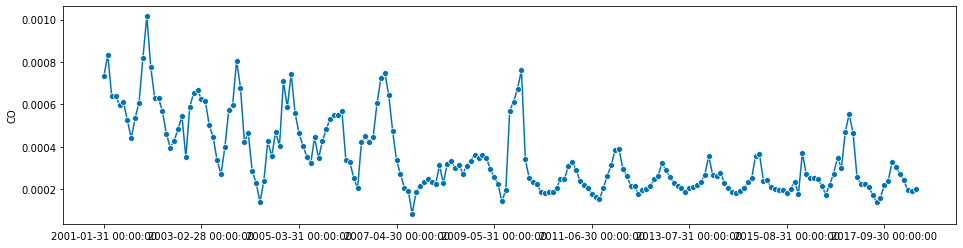

In [42]:
plot_series(monthly_campo['CO'])

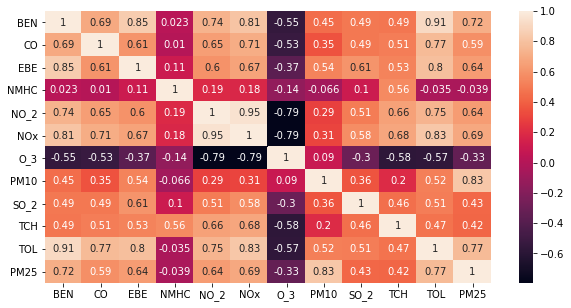

In [43]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(monthly_campo.corr(), annot = True, ax = ax)
plt.show()

In [44]:
#Select highly correlated columns
relevant_monthly = monthly_campo.drop(['NMHC', 'PM10'], axis = 1)
relevant_monthly

,BEN,CO,EBE,NO_2,NOx,O_3,SO_2,TCH,TOL,PM25
2001-01-31,0.414322,0.000732,0.884759,32.272773,58.505876,25.748446,11.735047,0.001433,4.459876,10.421379
2001-02-28,0.643197,0.000834,1.298526,40.763051,73.791451,28.087449,14.520818,0.001460,6.774207,12.176547
2001-03-31,0.756143,0.000638,1.083559,23.350578,34.725380,41.876160,10.301734,0.001368,3.866658,9.912690
2001-04-30,0.735552,0.000639,1.012272,24.128681,31.726316,53.294358,10.640417,0.001330,2.824384,10.456545
2001-05-31,0.983992,0.000597,1.280000,34.736183,42.970296,54.114328,10.941640,0.001367,4.227191,11.741705
...,...,...,...,...,...,...,...,...,...,...
2018-01-31,0.578258,0.000272,0.263169,29.869153,56.104371,31.226520,4.233548,0.001218,2.048348,8.583847
2018-02-28,0.547687,0.000244,0.196744,28.314673,43.036745,42.487002,4.010179,0.001207,1.377709,7.843136
2018-03-31,0.327136,0.000194,0.133265,11.387715,15.128316,70.995515,3.308548,0.001150,0.547322,4.741493
2018-04-30,0.266314,0.000193,0.143503,13.197750,17.072084,72.289810,3.547944,0.001196,0.742914,10.009485


In [45]:
#Creating lag variables
dataframe = pd.DataFrame()
for i in range(12, 0, -1):
    dataframe['t-' + str(i)] = relevant_monthly.CO.shift(i)
lagged_monthly = pd.concat([relevant_monthly, dataframe], axis = 1)
lagged_monthly.dropna(inplace = True)

In [46]:
#Adding seasonal variables
train1 = lagged_monthly.loc['2002-01-31' : '2017-11-30']
test1 = lagged_monthly.loc['2017-12-31' : '2018-05-31']
x_test1 = test1.loc[:, test1.columns != 'CO']
y_test1 = test1['CO']
x_train1 = train1.loc[:, train1.columns != 'CO']
y_train1 = train1['CO']

In [47]:
print("Training model...")
monthly_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
monthly_rfe = RFE(estimator = monthly_reg, n_features_to_select = 9)
monthly_fit = monthly_rfe.fit(x_train1, y_train1)

Training model...


In [48]:
col = RFE.get_support(monthly_fit).astype(int)
column_num = []
col = list(col)
col = [int(i) for i in col]
for index, col in enumerate(col):
    if col == 1:
        column_num.append(index)

In [49]:
monthly_x_train = x_train1.iloc[:, column_num]
monthly_x_test = x_test1.iloc[:, column_num]

In [50]:
monthly_x_train

,NO_2,NOx,O_3,TCH,TOL,PM25,t-8,t-2,t-1
2002-01-31,59.729503,106.668852,14.599180,0.001395,9.890778,17.400742,0.000597,0.000820,0.001016
2002-02-28,45.103795,77.333865,23.966161,0.001361,6.714597,15.324362,0.000612,0.001016,0.000777
2002-03-31,41.801989,57.084058,35.624688,0.001369,4.367144,13.821774,0.000525,0.000777,0.000632
2002-04-30,39.514931,48.580611,49.242208,0.001365,4.220787,12.919104,0.000441,0.000632,0.000629
2002-05-31,25.043481,30.850541,54.058965,0.001316,3.293904,10.182460,0.000535,0.000629,0.000568
...,...,...,...,...,...,...,...,...,...
2017-07-31,15.635390,7.768179,78.168367,0.001281,1.284839,10.273764,0.000471,0.000210,0.000174
2017-08-31,14.539597,9.037316,81.269174,0.001287,1.276712,11.861097,0.000554,0.000174,0.000141
2017-09-30,22.049250,14.617459,66.247775,0.001292,1.323843,7.812598,0.000463,0.000141,0.000160
2017-10-31,37.448454,52.563266,39.907697,0.001315,1.987425,9.613694,0.000259,0.000160,0.000219


In [51]:
new_monthly = monthly_reg.fit(monthly_x_train, y_train1)
monthly_predictions = new_monthly.predict(monthly_x_test)

In [52]:
import numpy as np
correct1 = np.array(y_test1)
sumvalue1 = np.sum(correct1)
mape1 = np.sum(np.abs((correct1 - monthly_predictions))) / sumvalue1 * 100
accuracy1 = 100 - mape1
print('Accuracy:', round(accuracy1, 2), '%.')

Accuracy: 86.66 %.


In [53]:
#calculating bias
monthly_errors = [correct1[i] - monthly_predictions[i] for i in range(len(correct1))]
monthly_bias = sum(monthly_errors) * 1.0/len(correct1)
print('Bias: %f' % monthly_bias)

Bias: -0.000031


The monthly data is more biased than the weekly data. This is to be expected as we are using a lot of averages.

In [54]:
df1 = pd.DataFrame(monthly_predictions)
df1['date'] = y_test1.index
df1['date'] = pd.to_datetime(df1.date, infer_datetime_format = True)
df1.index = df1['date']
df1 = df1.drop(['date'], axis = 1)
df1.index = pd.to_datetime(df1.index)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='CO'>)

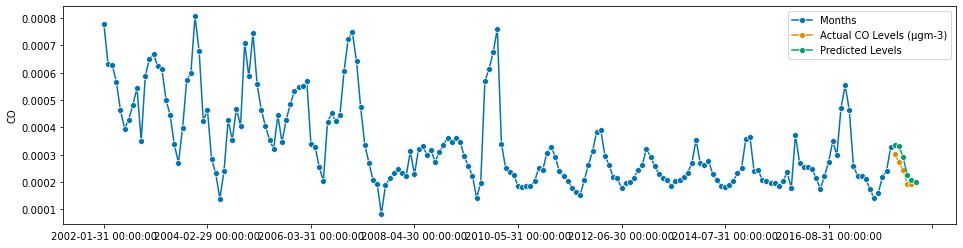

In [55]:
plot_series(y_train1, y_test1, df1, labels = ['Months', 'Actual CO Levels (μgm-3)', 'Predicted Levels'])

# Quarterly Resampling

In [56]:
quarterly_campo = campo_imputed.resample('Q').mean()
quarterly_campo.head()

,BEN,CO,EBE,NMHC,NO_2,NOx,O_3,PM10,SO_2,TCH,TOL,PM25
date,,,,,,,,,,,,
2001-03-31,0.603354,0.000732,1.082053,0.133766,31.840792,55.068738,32.034147,19.734104,12.108208,0.001419,4.975798,10.792388
2001-06-30,0.926514,0.000616,1.225781,0.116255,31.650980,39.580493,56.483128,29.200238,10.989826,0.001352,3.828098,12.490377
2001-09-30,0.854173,0.000500,1.068416,0.112409,32.734728,38.484621,56.109720,35.670643,11.300172,0.001366,4.129965,14.138307
2001-12-31,1.919570,0.000810,1.948412,0.157083,47.244264,95.405399,19.007608,32.020005,10.986782,0.001447,9.894141,17.654523
2002-03-31,1.636401,0.000681,1.566520,0.144306,49.004250,80.463205,24.755471,26.402093,3.996884,0.001375,7.000048,15.522001


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='CO'>)

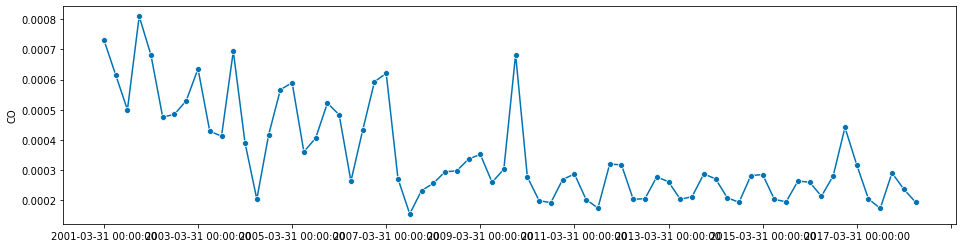

In [57]:
plot_series(quarterly_campo['CO'])

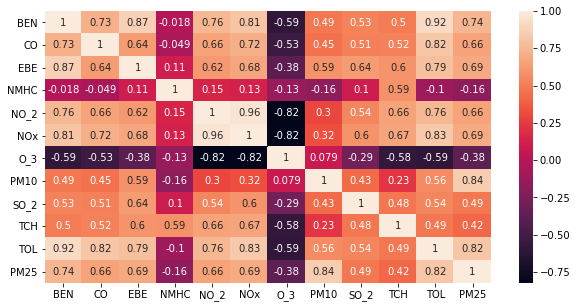

In [58]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(quarterly_campo.corr(), annot = True, ax = ax)
plt.show()

In [59]:
relevant_quarterly = quarterly_campo.drop(['NMHC'], axis = 1)
relevant_quarterly.head()

,BEN,CO,EBE,NO_2,NOx,O_3,PM10,SO_2,TCH,TOL,PM25
2001-03-31,0.603354,0.000732,1.082053,31.840792,55.068738,32.034147,19.734104,12.108208,0.001419,4.975798,10.792388
2001-06-30,0.926514,0.000616,1.225781,31.650980,39.580493,56.483128,29.200238,10.989826,0.001352,3.828098,12.490377
2001-09-30,0.854173,0.000500,1.068416,32.734728,38.484621,56.109720,35.670643,11.300172,0.001366,4.129965,14.138307
2001-12-31,1.919570,0.000810,1.948412,47.244264,95.405399,19.007608,32.020005,10.986782,0.001447,9.894141,17.654523
2002-03-31,1.636401,0.000681,1.566520,49.004250,80.463205,24.755471,26.402093,3.996884,0.001375,7.000048,15.522001


In [60]:
#Creating lag variables
dataframe = pd.DataFrame()
for i in range(4, 0, -1):
    dataframe['t-' + str(i)] = relevant_quarterly.CO.shift(i)
lagged_quarterly = pd.concat([relevant_quarterly, dataframe], axis = 1)
lagged_quarterly.dropna(inplace = True)

In [61]:
quarter_train = lagged_quarterly.loc['2002-03-31' : '2016-12-31']
quarter_test = lagged_quarterly.loc['2017-03-31' : '2018-03-31']
x_test2 = quarter_test.loc[:, quarter_test.columns != 'CO']
y_test2 = quarter_test['CO']
x_train2 = quarter_train.loc[:, quarter_train.columns != 'CO']
y_train2 = quarter_train['CO']

In [62]:
x_train2.shape

(60, 14)

In [63]:
quarterly_reg = RandomForestRegressor(n_estimators = 100, random_state = 42)
quarterly_rfe = RFE(estimator = quarterly_reg, n_features_to_select = 9)
quarterly_fit = quarterly_rfe.fit(x_train2, y_train2)
quarterly_predictions = quarterly_fit.predict(x_test2)

In [64]:
correct2 = np.array(y_test2)
sumvalue2 = np.sum(correct2)
mape = np.sum(np.abs((correct2 - quarterly_predictions))) / sumvalue2 * 100
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.37 %.


In [65]:
#calculating bias
quarterly_errors = [correct2[i] - quarterly_predictions[i] for i in range(len(correct2))]
quarterly_bias = sum(quarterly_errors) * 1.0/len(correct2)
print('Bias: %f' % quarterly_bias)

Bias: -0.000027


In [66]:
quarterly_df = pd.DataFrame(quarterly_predictions)
quarterly_df['date'] = y_test2.index
quarterly_df['date'] = pd.to_datetime(quarterly_df.date, infer_datetime_format = True)
quarterly_df.index = quarterly_df['date']
quarterly_df = quarterly_df.drop(['date'], axis = 1)
quarterly_df.index = pd.to_datetime(quarterly_df.index)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='CO'>)

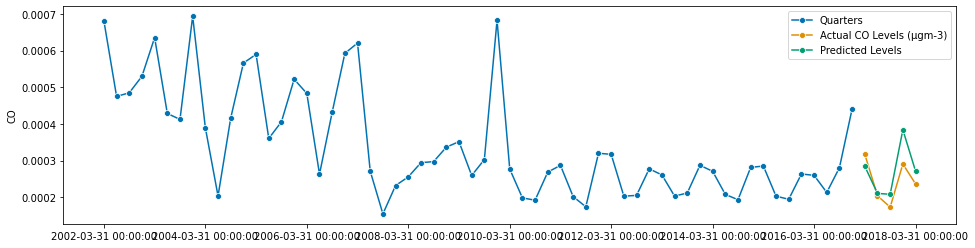

In [67]:
plot_series(y_train2, y_test2, quarterly_df, labels = ['Quarters', 'Actual CO Levels (μgm-3)', 'Predicted Levels'])

Weekly Resampling has the highest prediction accuracy of all the timeframes.